In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
# from scipy.stats import norm
import pyarrow.parquet as pq
import pandas as pd
from collections import namedtuple

/Users/arjunshah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading in data and prepping for analysis

In [ ]:
# Read in parquet file 
# table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")

table = pq.read_table("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")
# Convert to Panadas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define log-price to ensure positive values
df['log_price'] = np.log(df['underlying_price'])
# Define log-return
df['log_return'] = df['log_price'].diff().fillna(0)
# Define mid-price
df['mid_price'] = ((df['best_bid_price'] + df['best_ask_price']) / 2) 


# Define maturity in years
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['time_to_maturity'] = (df['expiry'] - reference_date).dt.days / 365.25 # Cryptocurrency is traded 24/7

# Convert strike to numeric
df['strike'] = pd.to_numeric(df['strike'], errors='coerce')
# Normalise strike
df['strike'] = df['strike'] / df['underlying_price']

# Group the DataFrame by 'time_stamp' and count unique 'time_to_maturity' values for each group
unique_counts = df.groupby('timestamp')['strike'].nunique()

# Identify the timestamp with the highest count of unique 'time_to_maturity' values
max_timestamp = unique_counts.idxmax()
max_count = unique_counts[max_timestamp]

# Snapshot where the count of unique 'time_to_maturity' values is highest
snapshot = df[(df['timestamp'] == max_timestamp) & (df['option_type'] == 'C')]

# Filter snapshot for open interest >0
snapshot = snapshot[snapshot['open_interest'] > 0]

# Convert 'strike' to numeric
# snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')

snapshot['mid_price'] = ((snapshot['best_bid_price'] + snapshot['best_ask_price']) / 2) # *snapshot['index_price']
snapshot['mark_price_usd'] = snapshot['mark_price']*snapshot['index_price']

snapshot = snapshot[['time_to_maturity', 'strike', 'mid_price', 'mark_price_usd', 'underlying_price', 'timestamp']]

# print(snapshot)

options_df = snapshot.copy()

options_df['maturity'] = options_df['time_to_maturity']
options_df['mid_market'] = options_df['mid_price'] 
options_df['underlying'] = options_df['underlying_price']
# options_df['strike'] = options_df['strike']/ options_df['underlying']
options_df['strike'] = options_df['strike']




options_df = options_df[['maturity', 'strike', 'mid_market', 'underlying', 'timestamp']]

print(options_df)

options_df = options_df.astype({
    'maturity': 'float32',
    'strike': 'float32',
    'mid_market': 'float32',
    'underlying': 'float32',
    'timestamp': 'datetime64[ns]'
})

print(options_df)

       maturity    strike  mid_market  underlying               timestamp
31951  0.156057  1.229879     0.02750   105701.43 2025-01-30 00:43:27.829
31959  0.156057  1.419091     0.01150   105701.43 2025-01-30 00:43:27.829
31961  0.156057  1.513688     0.00800   105702.11 2025-01-30 00:43:27.829
31963  0.156057  1.608304     0.00600   105701.43 2025-01-30 00:43:27.829
31965  0.156057  1.655607     0.00515   105701.43 2025-01-30 00:43:27.829
31967  0.156057  1.702910     0.00455   105701.43 2025-01-30 00:43:27.829
31969  0.156057  1.892122     0.00270   105701.43 2025-01-30 00:43:27.829
31973  0.156057  2.365152     0.00140   105701.43 2025-01-30 00:43:27.829
31975  0.156057  2.838183     0.00075   105701.43 2025-01-30 00:43:27.829
31977  0.405202  0.183983     0.81650   108705.69 2025-01-30 00:43:27.829
31979  0.405202  0.275975     0.72550   108705.69 2025-01-30 00:43:27.829
31981  0.405202  0.367966     0.63525   108705.69 2025-01-30 00:43:27.829
31983  0.405202  0.413962     0.59025 

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_92161/3607704161.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])


In [3]:
print(df[['strike', 'time_to_maturity', 'mid_price']])



         strike  time_to_maturity  mid_price
0      0.847634          0.000000    0.00000
1      0.847634          0.000000    0.00005
2      0.866898          0.000000    0.00000
3      0.866898          0.000000    0.00005
4      0.886162          0.000000    0.00000
...         ...               ...        ...
99995  0.787282          0.002738    0.21275
99996  0.787297          0.002738    0.00010
99997  0.796883          0.002738    0.20325
99998  0.796883          0.002738    0.00015
99999  0.806484          0.002738    0.19375

[100000 rows x 3 columns]


In [4]:
print(df.columns)

Index(['timestamp', 'state', 'index_price', 'instrument_name', 'last_price',
       'settlement_price', 'min_price', 'max_price', 'open_interest',
       'mark_price', 'best_ask_price', 'best_bid_price', 'interest_rate',
       'mark_iv', 'bid_iv', 'ask_iv', 'underlying_price', 'underlying_index',
       'best_ask_amount', 'best_bid_amount', 'estimated_delivery_price',
       'delivery_price', 'stats_high', 'stats_low', 'stats_price_change',
       'stats_volume', 'stats_volume_usd', 'greeks_delta', 'greeks_gamma',
       'greeks_rho', 'greeks_theta', 'greeks_vega', 'datetime', 'asset',
       'expiry', 'strike', 'option_type', 'log_price', 'log_return',
       'mid_price', 'time_to_maturity'],
      dtype='object')


In [31]:
price_history = df.copy()

# filter for >0 open interest
price_history = price_history[price_history['open_interest'] > 0]

# Filter for just calls
price_history = price_history[price_history['option_type'] == 'C']


# Normalised strke 
# price_history['strike'] = pd.to_numeric(price_history['strike'], errors='coerce')
# price_history['strike'] = price_history['strike'].values.astype('float32') / price_history['underlying_price']

# Filter for relevant columns
price_history = price_history[['timestamp', 'expiry', 'index_price', 'underlying_price','strike', 'best_bid_price', 'best_ask_price', 'mark_price', 'mid_price', 'time_to_maturity', 'option_type']]

price_history['time_to_maturity'] = price_history['time_to_maturity'].values.astype('float32')

price_history['mid_market'] = price_history['mid_price']

# Sort by the 'timestamp' column in increasing order
price_history = price_history.sort_values(by='timestamp', ascending=True)

price_history['strike'] = price_history['strike'].astype('float32')

price_history = price_history.astype({
    'time_to_maturity': 'float32',
    'strike': 'float32',
    'mid_market': 'float32',
    'index_price': 'float32',
    'underlying_price': 'float32',
    'timestamp': 'datetime64[ns]'
})

print(price_history)

# print(len(price_history))

# print(price_history['strike'].value_counts())


                    timestamp     expiry    index_price  underlying_price  \
14    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
18    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
16    2025-01-30 00:00:59.032 2025-01-30  103795.437500     103820.195312   
22    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
24    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
...                       ...        ...            ...               ...   
99979 2025-01-30 02:11:04.862 2025-01-31  104057.281250     104156.453125   
99997 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99993 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99995 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99999 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   

         strike  best_bid_price  best_ask_price  mark_price  mid_price  \
1

In [6]:
print(df[df['strike'] == (1.2531230449676514)])
print(options_df[options_df['strike'] == (1.2531230449676514)])

Empty DataFrame
Columns: [timestamp, state, index_price, instrument_name, last_price, settlement_price, min_price, max_price, open_interest, mark_price, best_ask_price, best_bid_price, interest_rate, mark_iv, bid_iv, ask_iv, underlying_price, underlying_index, best_ask_amount, best_bid_amount, estimated_delivery_price, delivery_price, stats_high, stats_low, stats_price_change, stats_volume, stats_volume_usd, greeks_delta, greeks_gamma, greeks_rho, greeks_theta, greeks_vega, datetime, asset, expiry, strike, option_type, log_price, log_return, mid_price, time_to_maturity]
Index: []

[0 rows x 41 columns]
Empty DataFrame
Columns: [maturity, strike, mid_market, underlying, timestamp]
Index: []


In [7]:
print(price_history[price_history['strike'] == (1.2531230449676514)])
print(price_history.dtypes)

Empty DataFrame
Columns: [timestamp, expiry, index_price, underlying_price, strike, best_bid_price, best_ask_price, mark_price, mid_price, time_to_maturity, option_type]
Index: []
timestamp           datetime64[ns]
expiry              datetime64[ns]
index_price                float32
underlying_price           float32
strike                     float32
best_bid_price             float64
best_ask_price             float64
mark_price                 float64
mid_price                  float32
time_to_maturity           float32
option_type                 object
dtype: object


In [8]:
print(options_df.dtypes)

maturity             float32
strike               float32
mid_market           float32
underlying           float32
timestamp     datetime64[ns]
dtype: object


In [43]:
print(price_history)


                    timestamp     expiry    index_price  underlying_price  \
14    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
18    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
16    2025-01-30 00:00:59.032 2025-01-30  103795.437500     103820.195312   
22    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
24    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
...                       ...        ...            ...               ...   
99979 2025-01-30 02:11:04.862 2025-01-31  104057.281250     104156.453125   
99997 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99993 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99995 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99999 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   

         strike  best_bid_price  best_ask_price  mark_price  mid_price  \
1

In [33]:
# Strike finder helper function
def find_strike_matches(df, strike_col, target_strike, min_rows=5, max_precision=6):
    # First try exact match
    exact_match = df[df[strike_col] == target_strike]
    if len(exact_match) >= min_rows:
        return exact_match

    # Gradually reduce decimal precision
    for precision in range(max_precision, 0, -1):
        rounding_factor = 10 ** -precision
        lower = np.floor(target_strike / rounding_factor) * rounding_factor
        upper = lower + rounding_factor
        approx_match = df[(df[strike_col] >= lower) & (df[strike_col] <= upper)]
        if len(approx_match) >= min_rows:
            return approx_match

# This is the Neural SDE model with calibration method for an entire timeseries
This is now calibrating to a timeseries option prices. There is a squared loss across the whole timeseries of options. The loss function of the parameters is being optimized/minimized to the model that had the highest loss. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- Hyperparameters ---
r                   = 0.0
nu                  = 0.5
rho                 = -0.3
alpha0              = 0.6
S0                  = 1.0
num_steps           = 100
num_paths_adv       = 500    # fewer paths for adversary updates
num_paths_gen       = 1000   # more paths for generator updates
epochs_per_maturity = 20
max_cand            = 50     # max history samples for adversary

# --- 1) Leverage‐net builder ---
def build_leverage_model():
    m = models.Sequential([
        layers.Input(shape=(2,)),  # [t, S_t]
        *[
            layer for _ in range(4)
            for layer in (layers.Dense(64), layers.LeakyReLU(alpha=0.2))
        ],
        layers.Dense(1, activation='softplus'),        # Fi(s) ≥ 0
        layers.Lambda(lambda f: 1.0 + f)               # L = 1 + Fi(s)
    ])
    return m

# --- 2) Adversary‐net builder ---
def build_adversary(N):
    return models.Sequential([
        layers.Input(shape=(N,)),
        layers.Dense(N, activation='softmax')
    ])

# --- 3) Black–Scholes delta for control variate ---
def bs_delta(S, K, T, r, sigma):
    d1  = (tf.math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*tf.sqrt(T))
    cdf = 0.5*(1.0 + tf.math.erf(d1 / tf.sqrt(2.0)))
    return 1
    # return tf.exp(-r*T) * cdf

# --- 4) Piecewise simulation (no @tf.function) ---
def simulate_S_and_alpha_segmented(T, leverage_nets, maturities, steps, paths):
    dt      = T / steps
    S       = tf.fill([paths], tf.cast(S0, tf.float32))
    alpha   = tf.fill([paths], tf.cast(alpha0, tf.float32))
    L_val   = tf.ones([paths], dtype=tf.float32)

    for k in range(steps):
        t = dt * (k + 1)
        # pick the first maturity ≥ t
        for Ti in maturities:
            if t <= Ti:
                net = leverage_nets[Ti]
                break

        inp   = tf.concat([
            tf.fill([paths,1], t),
            tf.reshape(S, (-1,1))
        ], axis=1)
        L_val = tf.reshape(net(inp), [-1])

        Z1 = tf.random.normal([paths], 0., 1.)
        Z2 = tf.random.normal([paths], 0., 1.)
        dW = tf.sqrt(dt) * Z1
        dB = tf.sqrt(dt) * (rho*Z1 + tf.sqrt(1.0-rho**2)*Z2)

        alpha = alpha + nu * alpha * dB
        S     = S + S * L_val * alpha * dW

    return S, alpha, L_val

# --- 5) MC price using piecewise sim + control variate ---
def monte_carlo_call_price_segmented(T, K, r,
                                     leverage_nets, maturities,
                                     steps, paths):
    S_T, alpha_T, L_T = simulate_S_and_alpha_segmented(
        T, leverage_nets, maturities, steps, paths
    )
    payoff    = tf.nn.relu(S_T - K)
    sigma_eff = alpha_T * L_T
    delta     = bs_delta(S_T, K, T, r, sigma_eff)
    # control   = delta * (S_T - S0)
    control = 0
    adj       = payoff - control
    return tf.exp(-r*T) * tf.reduce_mean(adj)

# --- 6) Adversarial loss (learned sup over history) ---
def adversarial_loss(model_price, hist, adv_net):
    prices = hist[:max_cand]
    if len(prices) < max_cand:
        prices = np.pad(prices, (0, max_cand - len(prices)), 'edge')
    errs  = tf.square(model_price - tf.constant(prices, tf.float32))
    gamma = adv_net(tf.expand_dims(errs,0))[0]   # softmax weights
    return tf.reduce_sum(gamma * errs)

# --- 7) Initialize nets & optimizers ---
unique_T      = sorted(options_df['maturity'].unique())
leverage_nets = {T: build_leverage_model() for T in unique_T}
adv_nets      = {T: build_adversary(max_cand) for T in unique_T}

opt_lev       = {T: optimizers.Adam(1e-3) for T in unique_T}
opt_adv       = {T: optimizers.Adam(1e-3) for T in unique_T}

adv_loss_history = {T: [] for T in unique_T}
gen_loss_history = {T: [] for T in unique_T}

# --- 8) Sequential, maturity-by-maturity calibration ---
for i, Ti in enumerate(unique_T):
    # a) freeze all earlier nets & adversaries
    for T_prev in unique_T[:i]:
        leverage_nets[T_prev].trainable = False
        adv_nets      [T_prev].trainable = False

    df_i = options_df[options_df['maturity'] == Ti]

    # b) train F_i (and its adversary) for this maturity
    for epoch in range(epochs_per_maturity):
        # ---- adversary ascent ----
        with tf.GradientTape() as tape_adv:
            adv_obj = tf.constant(0.0, tf.float32)
            for _, row in df_i.iterrows():
                hist = price_history[
                    (price_history['timestamp'] < row['timestamp']) &
                    (price_history['time_to_maturity'] == Ti)
                ]
                hist = find_strike_matches(hist, 'strike', row['strike'])

                hist = hist['mid_market'].values.astype(np.float32)

                mp = monte_carlo_call_price_segmented(
                    Ti, float(row['strike']), r,
                    leverage_nets, unique_T,
                    num_steps, num_paths_adv
                )
                adv_obj = adv_obj + adversarial_loss(mp, hist, adv_nets[Ti])

        grads_adv = tape_adv.gradient(
            adv_obj, adv_nets[Ti].trainable_variables
        )
        opt_adv[Ti].apply_gradients(
            zip(grads_adv, adv_nets[Ti].trainable_variables)
        )

        adv_loss_history[Ti].append(adv_obj.numpy())

        # ---- generator descent ----
        with tf.GradientTape() as tape_gen:
            gen_obj = tf.constant(0.0, tf.float32)
            for _, row in df_i.iterrows():
                hist = price_history[
                    (price_history['timestamp'] < row['timestamp']) &
                    (price_history['time_to_maturity'] == Ti)
                ]['mid_market'].values.astype(np.float32)

                mp = monte_carlo_call_price_segmented(
                    Ti, float(row['strike']), r,
                    leverage_nets, unique_T,
                    num_steps, num_paths_gen
                )
                gen_obj = gen_obj + adversarial_loss(mp, hist, adv_nets[Ti])

        grads_gen = tape_gen.gradient(
            gen_obj, leverage_nets[Ti].trainable_variables
        )
        opt_lev[Ti].apply_gradients(
            zip(grads_gen, leverage_nets[Ti].trainable_variables)
        )
        gen_loss_history[Ti].append(gen_obj.numpy())

    print(f"Calibrated leverage net for maturity T={Ti}")

# 2) Plot loss histories
plt.figure(figsize=(10,6))
for T in unique_T:
    plt.plot(gen_loss_history[T], label=f'Gen Loss (T={T})')
    plt.plot(adv_loss_history[T], label=f'Adv Loss (T={T})')

plt.title("Adversarial vs. Generator Loss History")
plt.xlabel("Epoch")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.show()

# 3) Plot model fit vs. today's mid-market prices
for T in unique_T:
    df_T = options_df[options_df['maturity'] == T]
    strikes        = df_T['strike'].values
    market_prices  = df_T['mid_market'].values
    # compute model prices (you can increase paths for smoother curve)
    model_prices = [
        monte_carlo_call_price_segmented(
            T, float(K), r,
            leverage_nets, unique_T,
            num_steps, num_paths_gen
        ).numpy()
        for K in strikes
    ]

    plt.figure(figsize=(8,5))
    plt.plot(strikes, market_prices, 'o', label='Market Mid Price')
    plt.plot(strikes, model_prices, '-', linewidth=2, label='Neural-SDE Model')
    plt.title(f'Model Fit vs. Market (Maturity T={T})')
    plt.xlabel('Strike')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()






/Users/arjunshah/Library/Python/3.9/lib/python/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Calibrated leverage net for maturity T=0.15605749189853668


A note: The shorter maturity really doesn't seem to be getting fit, despite the loss function reducing and becoming stable. In saying this there were notable differences in the fit of the shorter maturity 

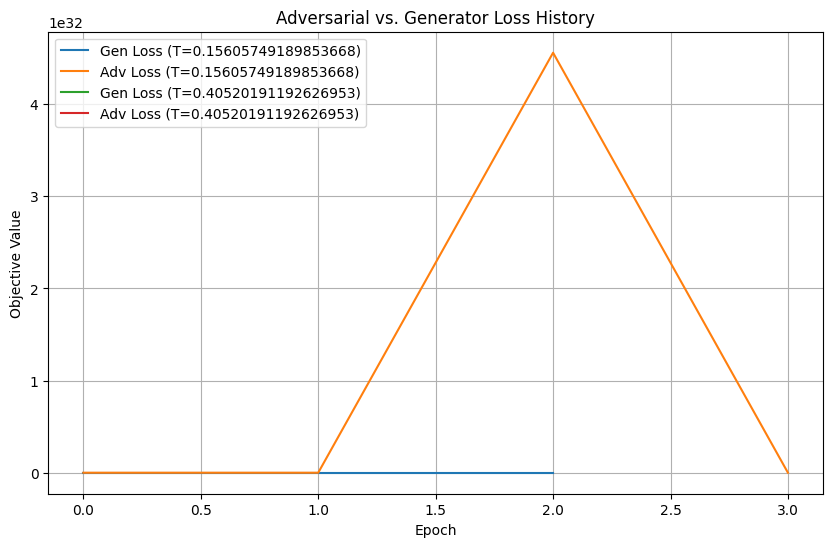

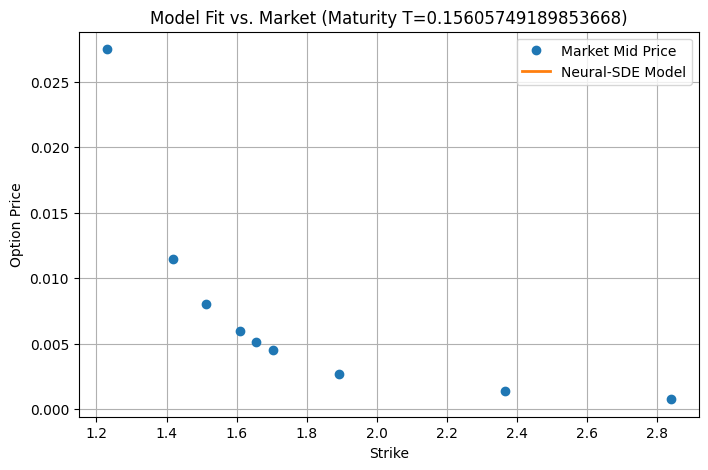

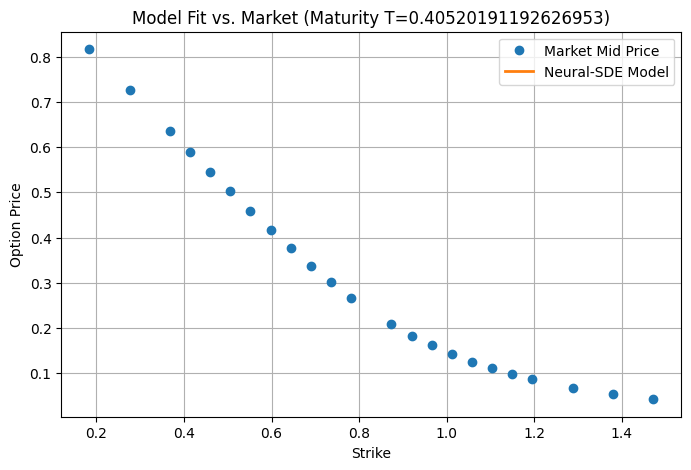

In [41]:
# 2) Plot loss histories
plt.figure(figsize=(10,6))
for T in unique_T:
    plt.plot(gen_loss_history[T], label=f'Gen Loss (T={T})')
    plt.plot(adv_loss_history[T], label=f'Adv Loss (T={T})')

plt.title("Adversarial vs. Generator Loss History")
plt.xlabel("Epoch")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.show()

# 3) Plot model fit vs. today's mid-market prices
for T in unique_T:
    df_T = options_df[options_df['maturity'] == T]
    strikes        = df_T['strike'].values
    market_prices  = df_T['mid_market'].values
    # compute model prices (you can increase paths for smoother curve)
    model_prices = [
        monte_carlo_call_price_segmented(
            T, float(K), r,
            leverage_nets, unique_T,
            num_steps, num_paths_gen
        ).numpy()
        for K in strikes
    ]

    plt.figure(figsize=(8,5))
    plt.plot(strikes, market_prices, 'o', label='Market Mid Price')
    plt.plot(strikes, model_prices, '-', linewidth=2, label='Neural-SDE Model')
    plt.title(f'Model Fit vs. Market (Maturity T={T})')
    plt.xlabel('Strike')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for epoch in range(num_epochs):
    loss_total_by_T = {T: 0.0 for T in unique_maturities}
    count_by_T = {T: 0 for T in unique_maturities}
    gen_loss_dict = {}
    with tf.GradientTape(persistent=True) as tape_gen:
        for idx, row in options_df.iterrows():
            T = float(row['maturity'])
            K = float(row['strike'])
            market_price = float(row['mid_market'])
            model_net = leverage_models[T]
            # Gain historical prices for the same (T,K)
            current_time = row['timestamp']
            
            local_price_history = (price_history[price_history['timestamp'] < current_time]) # Filter for past prices

            # print(local_price_history)

            test = local_price_history
            

            local_price_history = local_price_history[local_price_history['time_to_maturity'] == (T)] # Filter for same maturity

            local_price_history = find_strike_matches(local_price_history, 'strike', K)
                   
            # Get model price
            model_price = monte_carlo_call_price(
                T, K, S0, r, alpha0, model_net,
                num_steps=100, num_paths=1000
            )
            option_loss = robust_loss(model_price, local_price_history, market_price)
            # print(option_loss)
            loss_total_by_T[T] += option_loss
            count_by_T[T] += 1
        for T in unique_maturities:
            if count_by_T[T] > 0:
                loss_total_by_T[T] /= count_by_T[T]
            gen_loss_dict[T] = loss_total_by_T[T]

    for T in unique_maturities:
        model = leverage_models[T]
        grads_gen = tape_gen.gradient(gen_loss_dict[T], model.trainable_variables)
        optimizer_dict[T].apply_gradients(zip(grads_gen, model.trainable_variables))
        adv_loss_history[T].append(gen_loss_dict[T].numpy())
    del tape_gen

    if epoch % 5 == 0:
        losses_str = ", ".join(
            [f"T={T}: RobustGenLoss={gen_loss_dict[T].numpy():.4f}"
             for T in unique_maturities]
        )
        print(f"Epoch {epoch}: {losses_str}")

model_prices = []
for idx, row in options_df.iterrows():
    T = float(row['maturity'])
    K = float(row['strike'])
    model_net = leverage_models[T]
    price = monte_carlo_call_price(
        T, K, S0, r, alpha0, model_net,
        num_steps=100, num_paths=5000
    )
    model_prices.append(price.numpy())

options_df['model_price'] = model_prices
 
# Plot calibration results (market vs. model prices) for each maturity.
for T_val in options_df['maturity'].unique():
    subset = options_df[options_df['maturity'] == T_val]
    plt.figure()
    plt.plot(subset['strike'], subset['mid_market'], 'bo', label='Market Mid Price')
    plt.plot(subset['strike'], subset['model_price'], 'r-', label='Neural SDE Price')
    plt.title(f'Call Prices for Maturity T={T_val} (Adversarial Calibration)')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()
 
# Plot training loss history for each maturity.
plt.figure()
for T in unique_maturities:
    plt.plot(adv_loss_history[T], label=f'Maturity {T}')
plt.title("Adversarial Training Loss History by Maturity")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

plt.show()

/Users/arjunshah/Library/Python/3.9/lib/python/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


KeyError: 'mid_market'